# Analyse des données de systèmes éducatifs

### Consignes Open Classroom : 

- Valider la qualité de ce jeu de données (comporte-t-il beaucoup de données manquantes, dupliquées ?)
- Décrire les informations contenues dans le jeu de données (nombre de colonnes ? nombre de lignes ?)
- Sélectionner les informations qui semblent pertinentes pour répondre à la problématique (quelles sont les colonnes contenant des informations qui peuvent être utiles pour répondre à la problématique de l’entreprise ?)
- Déterminer des ordres de grandeurs des indicateurs statistiques classiques pour les différentes zones géographiques et pays du monde (moyenne/médiane/écart-type par pays et par continent ou bloc géographique)

Ton travail va nous permettre de déterminer si ce jeu de données peut informer les décisions d'ouverture vers de nouveaux pays. On va partager ton analyse avec le board, alors merci de soigner la présentation et de l'illustrer avec des graphiques pertinents et lisibles !

In [1]:
"""EDTECH"""

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import scipy.io
import time
import calendar
from datetime import datetime
import urllib
from sklearn.model_selection import train_test_split
import json 
import re
from tqdm import tqdm
import nltk.data
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import seaborn as sns
import importlib
from os.path import isfile, join
from functools import reduce
from matplotlib.patches import Patch

#LOAD
mypath=r'C:\Users\Utilisateur\Desktop\doc_openCl\P2\data'

FILE= "\EdStatsCountry.csv"
df_Country=pd.read_csv(r'C:\Users\Utilisateur\Desktop\doc_openCl\P2\data' +FILE, delimiter= ',')

FILE= "\EdStatsCountry-Series.csv"
df_Country_Series=pd.read_csv(r'C:\Users\Utilisateur\Desktop\doc_openCl\P2\data' +FILE, delimiter= ',')

FILE= "\EdStatsData.csv"
df_Data=pd.read_csv(r'C:\Users\Utilisateur\Desktop\doc_openCl\P2\data' +FILE, delimiter= ',')

FILE= "\EdStatsFootNote.csv"
df_FootNote=pd.read_csv(r'C:\Users\Utilisateur\Desktop\doc_openCl\P2\data' +FILE, delimiter= ',')

FILE= "\EdStatsSeries.csv"
df_Series=pd.read_csv(r'C:\Users\Utilisateur\Desktop\doc_openCl\P2\data' +FILE, delimiter= ',')


## I. Analyse exploratoire des données


### Taille des fichiers

In [2]:
print('le fichier {} à {} lignes et {} colonnes'.format(str('EdStatsCountry.csv'),df_Country.shape[0],df_Country.shape[1]))
print('le fichier {} à {} lignes et {} colonnes'.format(str('EdStatsCountry-Series.csv'),df_Country_Series.shape[0],df_Country_Series.shape[1]))
print('le fichier {} à {} lignes et {} colonnes'.format(str('EdStatsData.csv'),df_Data.shape[0],df_Data.shape[1]))
print('le fichier {} à {} lignes et {} colonnes'.format(str('EdStatsFootNote.csv'),df_FootNote.shape[0],df_FootNote.shape[1]))
print('le fichier {} à {} lignes et {} colonnes'.format(str('EdStatsSeries.csv'),df_Series.shape[0],df_Series.shape[1]))


le fichier EdStatsCountry.csv à 241 lignes et 32 colonnes
le fichier EdStatsCountry-Series.csv à 613 lignes et 4 colonnes
le fichier EdStatsData.csv à 886930 lignes et 70 colonnes
le fichier EdStatsFootNote.csv à 643638 lignes et 5 colonnes
le fichier EdStatsSeries.csv à 3665 lignes et 21 colonnes


### Valeurs manquantes dans les fichiers annexes

In [3]:
def nan_plot(df,title):
    cmap = sns.mpl_palette("Set2", 2)
    fig, ax = plt.subplots(figsize=(16,8))
    sns.heatmap(df.T.isna(), cmap=cmap,cbar=False)
    ax.set_title('Repartition des valeurs manquantes dans {}'.format(title), fontsize=16)
    ax.set_xlabel('Indice du pays', fontsize=16)
    legend_handles = [Patch(color=cmap[True], label='valeurs manquantes'),  # red
                      Patch(color=cmap[False], label='valeurs presentes')]  # green
    plt.legend(handles=legend_handles, ncol=2,  loc='upper right', fontsize=15, handlelength=.8)
    plt.tight_layout()
    plt.show()



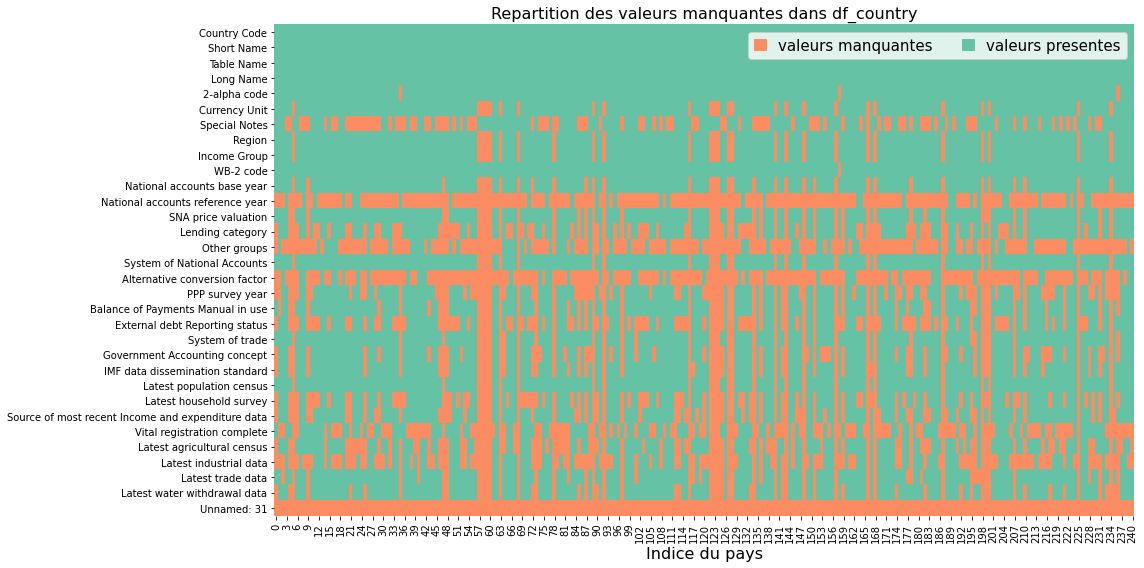

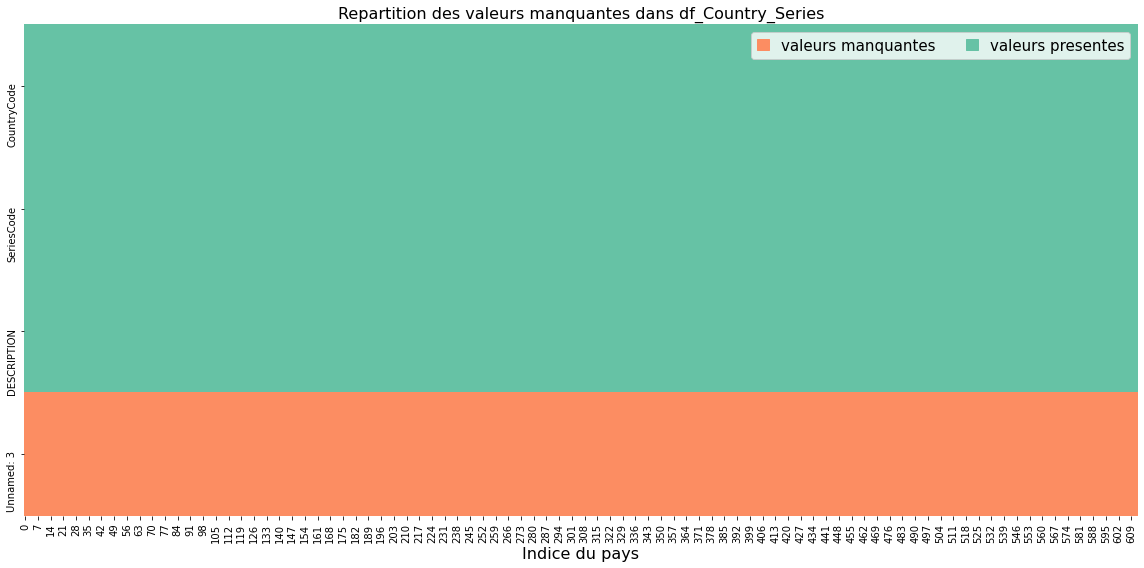

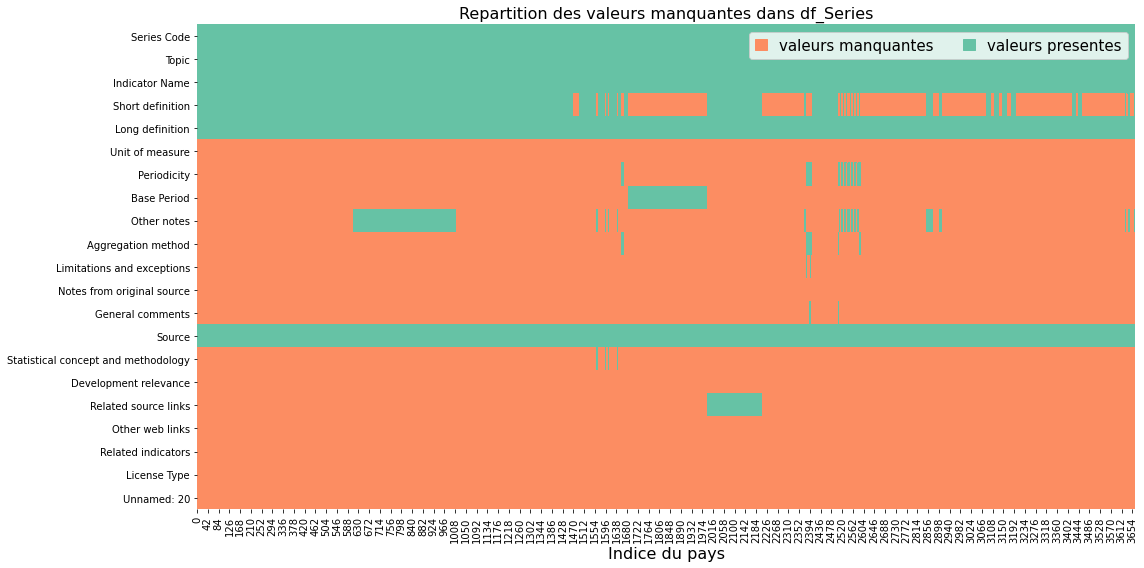

In [4]:
nan_plot(df_Country, 'df_country')
nan_plot(df_Country_Series, 'df_Country_Series')
nan_plot(df_Series, 'df_Series')



### Valeurs manquantes dans le fichier EdStatsData

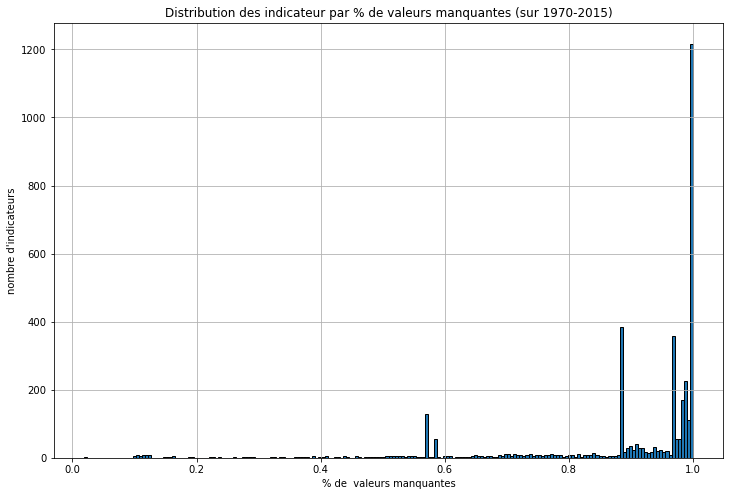

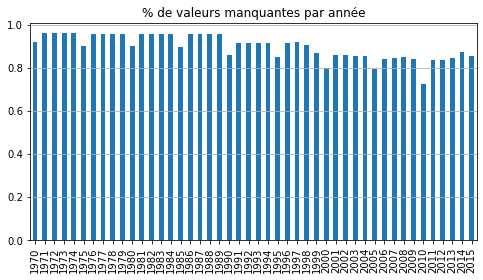

In [5]:
#  % NAN
df_Data_test=df_Data.copy()

#%nan on 2016
df_Data_test.set_index('Indicator Name', inplace=True)
ttest=df_Data_test['2016'].isna().groupby('Indicator Name').mean()

#nan/année : 
df_Data_test=df_Data.copy()
df_Data_test.set_index('Indicator Name', inplace=True)    

df_indic_perc=df_Data_test.isna().groupby('Indicator Name').mean()
i=df_indic_perc.columns.get_loc("1970")
j=df_indic_perc.columns.get_loc("2016")
df_indic_perc=df_indic_perc.iloc[:,i:j]#%nan on 1970-2015

perc_nan_by_year=df_indic_perc.mean(axis=0)
perc_nan_by_indic=df_indic_perc.mean(axis=1)# mean % nan for all years (or 1970-2015)

plt.figure(figsize=(12,8))
plt.hist(perc_nan_by_indic,bins=200,edgecolor='black')
plt.title('Distribution des indicateur par % de valeurs manquantes (sur 1970-2015)')
plt.xlabel('% de  valeurs manquantes')
plt.ylabel("nombre d'indicateurs")
plt.grid()

plt.figure(figsize=(8,4))
perc_nan_by_year.plot(kind='bar')
plt.title('% de valeurs manquantes par année')
plt.grid(axis='y')


### Commentaires
- beaucoup de valeurs manquantes
- particulièrement de 1970 à 1990
--> td : check sur periode 1970 -2100 (mm graph)

-->Determination d'un seuil de valeurs nulles  au decà du quel selectionner les indicateur

-> Enlever les regions -garder uniquement les pays

In [6]:
#FILTRE %nan <90%
df=df_Data.copy()
good_indic=perc_nan_by_indic[perc_nan_by_indic<0.90].index.to_list()#works

#Resize Dataframes
df=df[df['Indicator Name'].isin(good_indic)]#filter df_data
df_Series=df_Series[df_Series['Indicator Name'].isin(good_indic)]#filter df_Series

print('Apres filtrage des indicateurs contenant au maximum 90% de NaN, le DataFrame \
ne contient plus que {} lignes sur les {} initiales.'.format(df.shape[0],df_Data.shape[0]))

print('Cela correspond à {} indicateurs, sur les {} initiaux.'.format(len(df[ 'Indicator Name'].unique()), len(df_Data[ 'Indicator Name'].unique())))



Apres filtrage des indicateurs contenant au maximum 90% de NaN, le DataFrame ne contient plus que 283624 lignes sur les 886930 initiales.
Cela correspond à 1172 indicateurs, sur les 3665 initiaux.


## II. Selection des variables pertinentes

Une des difficultés de ce projet repose sur le nombre important d'indicateur (répartis pas Topic) parmis lesquels il en faut choisir judicieusement un nombre restreint qui, une fois combinés, pourrons nous donner  une idée claire et facilement interpretable du potentiel marché des pays.

    
Dans un premier temps nous selectionnerons 2 types d'indicateurs:

    Indicateurs generaux : 
        - Population
        - Alphabetisation
        - Taux d'acces à internet
    
    Indicateurs politico-economiques :
        - Nombre d'élèves par professeur d'université
        - Pourcentage de la population en age d'entreprendre des études universitaires
        - Depense Gouvernementales en faveur de l'education (en % du pib) ??

Tous ces indicateurs vont dans le même sens. Donc plus chacun d'eux est elevé, plus le potentiel marché (PM) d'un pays sera est élevé. 
L'indicateur sera donc du type: <br><br>
PM= $αInd_{1}$ + $βInd_{2}$ +...+ $ζInd_{n}$ <br><br>
où α, β,.. sont les poids que l'on souhaite associer à chaque indicateur. Par exemple bon taux d'accès à internet étant une condition sine qua none au développement de la plateforme en ligne, ce dernier sera affecté d'un poids important.


In [22]:
Topic=pd.DataFrame(df_Series.groupby('Topic').size())
Topic.rename(columns={0:"Decompte"}, inplace=True)
Topic.sort_values(by ="Decompte" , ascending = False,inplace=True)
Topic

,Decompte
Topic,
Attainment,360
Secondary,202
Primary,172
Population,161
Tertiary,71
Expenditures,40
Teachers,29
Pre-Primary,14
Early Childhood Education,14


In [33]:

def select_top(topic):
    '''select indicators from topic and add % of nan'''
    df=df_Series[df_Series['Topic']==topic][['Indicator Name','Long definition','Short definition']].copy()
    df=df.merge(pd.DataFrame(perc_nan_by_indic), on=['Indicator Name'], how='left' )
    df=df.rename(columns = {0:'% of nan'})
    return df



#----------GENERAL
Pop_structure=select_top('Health: Population: Structure')
#->Population of the official age for tertiary education, both sexes (number)
#-> Population, ages 15-24, male

Literacy=select_top('Literacy')
#-> Youth literacy rate, population 15-24 years, both sexes (%)

Infrastructure=select_top('Infrastructure: Communications')
#-> Internet users (per 100 people)  // Personal computers (per 100 people)


#------------INSTITUTION
Expenditures=select_top('Expenditures')
#Government expenditure on education as % of GDP (%) -> 68% of nan

Teachers=select_top('Teachers')
#->Pupil-teacher ratio in tertiary education (headcount basis)

Tertiary=select_top('Tertiary')

#indicateur, finiqshes secondary but not entered tertiary ?
Attainment=select_top('Attainment')

In [34]:
def get_indic(indic):
    df_0=df[df['Indicator Name']==indic]
    Serie=df_0.set_index('Country Name').T.apply(lambda x: x[x.notnull()].values[-1] if len(x[x.notnull()])>4 else np.nan) 
    df_1=pd.DataFrame(Serie).reset_index()
    df_1.rename(columns = {0:indic},inplace=True)
    return df_1

Pop_totale=get_indic('Population, total')
Ind_internet=get_indic('Internet users (per 100 people)')
Ind_literacy=get_indic('Youth literacy rate, population 15-24 years, both sexes (%)')
Ind_Teacher=get_indic('Pupil-teacher ratio in tertiary education (headcount basis)')

Ind_Tertiary=get_indic('Population of the official age for tertiary education, both sexes (number)')
Ind_Tertiary['Population of the official age for tertiary education, both sexes (%)']=\
    (Ind_Tertiary['Population of the official age for tertiary education, both sexes (number)']/Pop_totale['Population, total'])*100
Ind_Tertiary.drop('Population of the official age for tertiary education, both sexes (number)',axis=1,inplace=True)


IND=[Ind_internet,Ind_literacy,Ind_Tertiary,Ind_Teacher,Pop_totale]
df_ind = reduce(lambda  left,right: pd.merge(left,right,on=['Country Name'],how='outer'), IND)

df_ind


,Country Name,Internet users (per 100 people),"Youth literacy rate, population 15-24 years, both sexes (%)","Population of the official age for tertiary education, both sexes (%)",Pupil-teacher ratio in tertiary education (headcount basis),"Population, total"
0,Arab World,36.868602,88.964699,9.566587,NaN,3.697615e+08
1,East Asia & Pacific,52.796321,99.004402,7.684882,NaN,2.296786e+09
2,East Asia & Pacific (excluding high income),48.386621,98.969109,7.994111,NaN,2.051431e+09
3,Euro area,80.446726,NaN,5.388344,NaN,3.408946e+08
4,Europe & Central Asia,73.914751,99.711449,6.350682,NaN,9.119953e+08
...,...,...,...,...,...,...
237,Virgin Islands (U.S.),59.608316,NaN,NaN,NaN,1.029510e+05
238,West Bank and Gaza,61.178385,99.383710,10.965479,26.140511,4.551566e+06
239,"Yemen, Rep.",24.579208,NaN,10.608441,32.214790,2.758421e+07
240,Zambia,25.506579,88.714560,9.026706,13.118470,1.659139e+07


In [35]:
a=df_ind['Youth literacy rate, population 15-24 years, both sexes (%)'].isna().sum()
print('% de valeurs manquantes pour indicateur Alphabétisation : ',round(a/len(df_ind)*100,2),'%')

% de valeurs manquantes pour indicateur Alphabétisation :  31.82 %


### Problème des valeurs manquantes pour l'indicateur Alphabétisation
Il apparait que nombre des pays qui n'ont pas de valeurs pour l'indicateur alphabetisation sont des pays riches. Il semble très probable que ces derniers aient depuis longtemps un taux si proche de 100% que ce dernier ne soit plus renseigné. <br>
Afin de creer un indicateur composite (le but de cette analyse) qui soit applicable à  la plus grande majorité des pays nous metterons en place la methodologie suivante:
- Les pays sont classés par 'Income Group' (fichier EdStatsCountry.csv) <br> <br>
- Si un pays appartient au groupe des pays riches (Catégorie 'High income') , son taux d'alphabetisation sera associé automatiquement à 100%.





In [36]:
idx_l=[]
#replace literracy by 100 for countries with nan and belonging to high income countries
for i in df_ind[df_ind['Youth literacy rate, population 15-24 years, both sexes (%)'].isnull()]['Country Name']:#Works but ugly
    if df_Country['Table Name'].str.contains(i).any():
        x=df_Country[df_Country['Table Name']==i]['Income Group'].values[0]
        if(x=='High income: nonOECD')or (x=='High income: OECD'):
            idx=df_ind[df_ind['Country Name']==i].index 
            idx_l.append(idx[0])

df_ind.loc[idx_l, "Youth literacy rate, population 15-24 years, both sexes (%)"]=100


df_ind[['Country Name', "Youth literacy rate, population 15-24 years, both sexes (%)"]]\
    .sort_values(by="Youth literacy rate, population 15-24 years, both sexes (%)",ascending=False)

#including population in internet users
#df_ind['Internet users (per 100 people)']=df_ind['Internet users (per 100 people)']/100*df_ind['Population, total']


C:\Users\Utilisateur\anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



,Country Name,"Youth literacy rate, population 15-24 years, both sexes (%)"
119,Israel,100.0
41,Barbados,100.0
46,Bermuda,100.0
60,Canada,100.0
61,Cayman Islands,100.0
...,...,...
218,Timor-Leste,NaN
224,Turkmenistan,NaN
226,Tuvalu,NaN
237,Virgin Islands (U.S.),NaN


## III. Creation de l'indicateur "Potentiel marché"

In [37]:
#Filtrage Aditionnel

#FILTER REGIONS
Region=['World','Low & middle income','Middle income','Lower middle income','Upper middle income','East Asia & Pacific',
        'East Asia & Pacific (excluding high income)','South Asia','OECD members','High income','Sub-Saharan Africa',
        'Sub-Saharan Africa (excluding high income)','Least developed countries: UN classification','Europe & Central Asia',
        'Heavily indebted poor countries (HIPC)','Low income','Latin America & Caribbean','Latin America & Caribbean (excluding high income)',
        'European Union','Middle East & North Africa','Europe & Central Asia (excluding high income)','Middle East & North Africa (excluding high income)',
        'Arab World','North America','Euro area']

df_ind=df_ind[~df_ind['Country Name'].isin(Region)]

#Deleting China (complicate to access the market). India (for clarety) (-> pick India and have a look)
#Drop China
idx=df_ind[df_ind['Country Name']=='China'].index
df_ind=df_ind.drop(idx,axis=0)
#Drop India
idx=df_ind[df_ind['Country Name']=='India'].index
df_ind=df_ind.drop(idx,axis=0)

#Drop US
#idx=df_ind[df_ind['Country Name']=='United States'].index
#df_ind=df_ind.drop(idx,axis=0)

In [38]:
#CREATION INDICATEUR Composite
df_ind['Potentiel Marché']= df_ind[df_ind.columns[1]]\
*df_ind[df_ind.columns[2]]*df_ind[df_ind.columns[3]]*df_ind[df_ind.columns[4]]
df_ind.sort_values(by='Potentiel Marché',ascending=False)

,Country Name,Internet users (per 100 people),"Youth literacy rate, population 15-24 years, both sexes (%)","Population of the official age for tertiary education, both sexes (%)",Pupil-teacher ratio in tertiary education (headcount basis),"Population, total",Potentiel Marché
214,Syrian Arab Republic,31.869627,92.45381,9.520113,64.406418,18430453.0,1.806646e+06
223,Turkey,58.347734,99.49439,8.049082,38.420639,79512426.0,1.795285e+06
238,West Bank and Gaza,61.178385,99.38371,10.965479,26.140511,4551566.0,1.742829e+06
100,Greece,69.087915,98.69457,5.535679,44.506210,10746740.0,1.679913e+06
35,Australia,88.238658,100.00000,6.640450,27.472490,24127159.0,1.609735e+06
...,...,...,...,...,...,...,...
224,Turkmenistan,17.990324,NaN,9.822776,NaN,5662544.0,NaN
225,Turks and Caicos Islands,NaN,100.00000,NaN,NaN,34900.0,NaN
226,Tuvalu,46.009152,NaN,9.389925,NaN,11097.0,NaN
237,Virgin Islands (U.S.),59.608316,NaN,NaN,NaN,102951.0,NaN


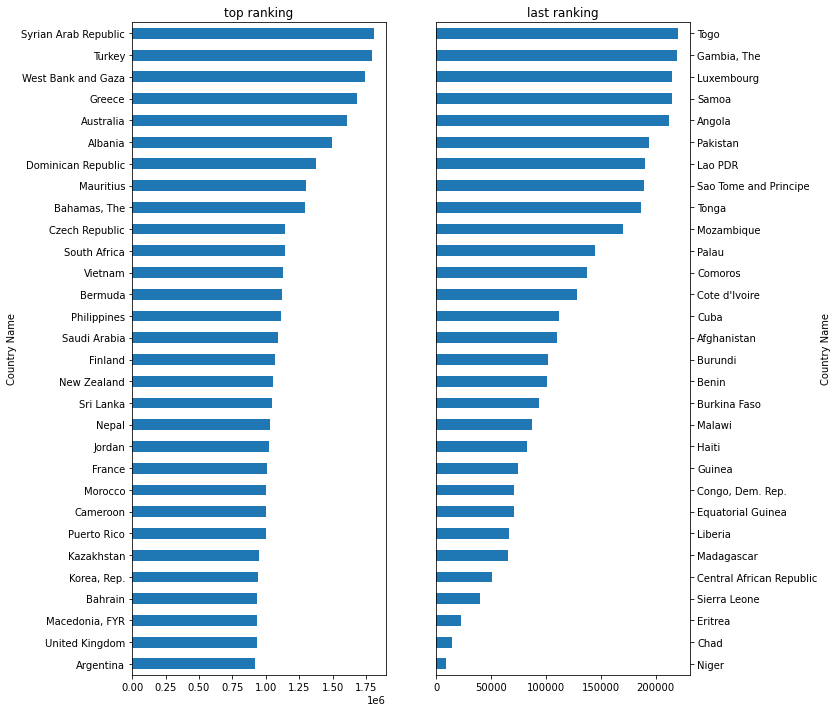

In [39]:
df_test=df_ind.copy()
df_test.set_index('Country Name', inplace=True)

plt.subplot(1,2,1)
x=df_test['Potentiel Marché'].sort_values(ascending=False)
x[0:30].sort_values(ascending=True).plot(kind='barh', figsize=(10,12), title="top ranking")

plt.subplot(1,2,2)
x=df_test['Potentiel Marché'].sort_values(ascending=True)
x[0:30].sort_values(ascending=True).plot(kind='barh', figsize=(10,12), title="last ranking")

plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()


## IV.Second Eda

Index(['Country Name', 'Internet users (per 100 people)',
       'Youth literacy rate, population 15-24 years, both sexes (%)',
       'Population of the official age for tertiary education, both sexes (%)',
       'Pupil-teacher ratio in tertiary education (headcount basis)',
       'Population, total', 'Potentiel Marché'],
      dtype='object')

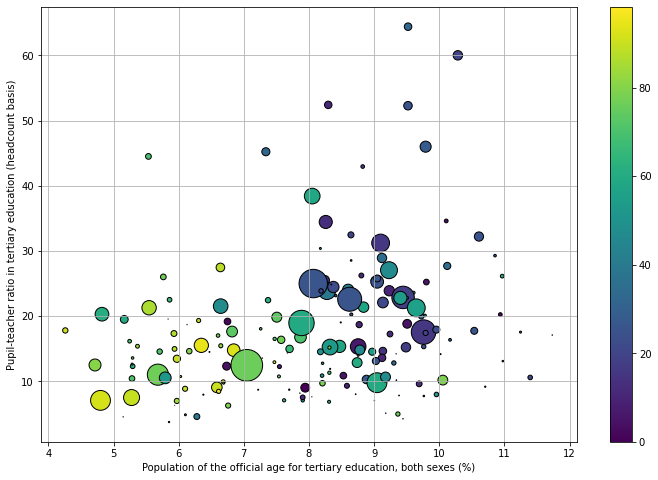

In [40]:
from sklearn import preprocessing
x = df_ind['Population, total'].values.reshape(-1, 1) #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

df_ind.columns

plt.figure(figsize=(12,8))
plt.scatter((df_ind[ 'Population of the official age for tertiary education, both sexes (%)']),
            df_ind['Pupil-teacher ratio in tertiary education (headcount basis)'],
            s=x_scaled*1000,
            c=df_ind['Internet users (per 100 people)'],
            edgecolors='black')
plt.xlabel("Population of the official age for tertiary education, both sexes (%)")
plt.ylabel("Pupil-teacher ratio in tertiary education (headcount basis)")
plt.grid()
plt.colorbar()

df_ind.columns

#USE COLOUR TOO
#ADD LEGEND FOR SIZE

In [41]:
import plotly.express as px
df_ind['Population, total']=df_ind['Population, total'].fillna(0)

fig = px.scatter(df_ind, x='Population of the official age for tertiary education, both sexes (%)',
                 y='Pupil-teacher ratio in tertiary education (headcount basis)',
                 size='Population, total',
                 color = 'Internet users (per 100 people)',
                 hover_name='Country Name')

fig.show()

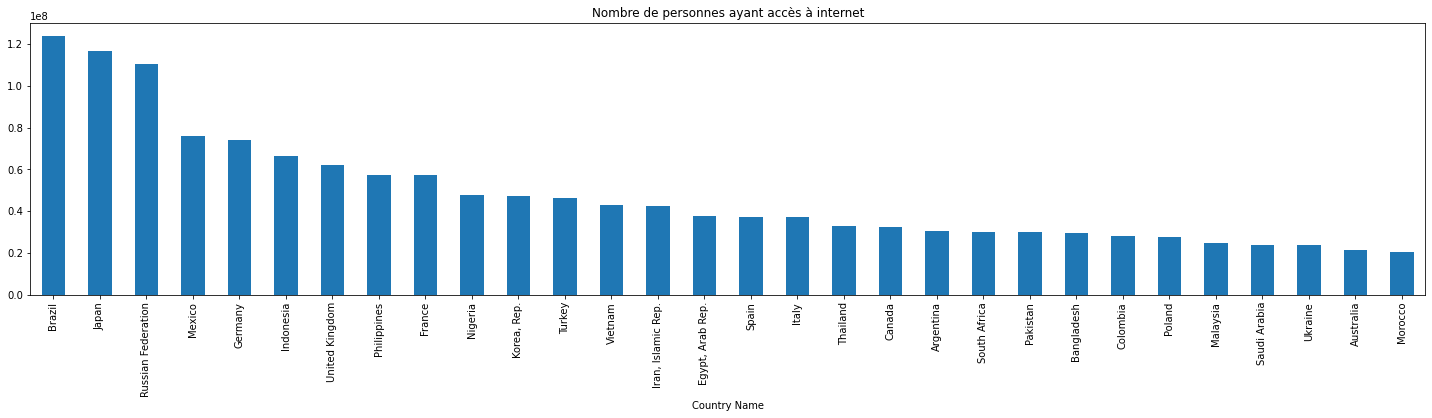

In [17]:
#HIST INTERNET
df_test=df_ind.copy()
df_test.set_index('Country Name', inplace=True)

#x=(df_test['Personal computers (per 100 people)']*df_test['Population, total']/100).sort_values(ascending=False)
#x[0:30].sort_values(ascending=False).plot(kind='bar', figsize=(25,5), title="Nombre de PC dans le pays")

x=(df_test['Internet users (per 100 people)']*df_test['Population, total']/100).sort_values(ascending=False)
x[0:30].sort_values(ascending=False).plot(kind='bar', figsize=(25,5), title="Nombre de personnes ayant accès à internet")


In [18]:
df_ind.columns

Index(['Country Name', 'Internet users (per 100 people)',
       'Youth literacy rate, population 15-24 years, both sexes (%)',
       'Population of the official age for tertiary education, both sexes (%)',
       'Pupil-teacher ratio in tertiary education (headcount basis)',
       'Population, total', 'Potentiel Marché'],
      dtype='object')

In [31]:
#including population in internet users
df_ind['Internet users (per 100 people)']=df_ind['Internet users (per 100 people)']/100*df_ind['Population, total']

#CREATION INDICATEUR Composite (modif)
df_ind['Potentiel Marché']= df_ind[df_ind.columns[1]]\
*df_ind[df_ind.columns[2]]*df_ind[df_ind.columns[3]]*df_ind[df_ind.columns[4]]
df_ind.sort_values(by='Potentiel Marché',ascending=False)

,Country Name,Internet users (per 100 people),"Youth literacy rate, population 15-24 years, both sexes (%)","Population of the official age for tertiary education, both sexes (%)",Pupil-teacher ratio in tertiary education (headcount basis),"Population, total",Potentiel Marché
231,United States,2.461480e+08,100.00000,7.045321,12.461140,323127513.0,2.161001e+12
51,Brazil,1.239329e+08,98.84569,7.884729,18.955730,207652865.0,1.830930e+12
223,Turkey,4.639370e+07,99.49439,8.049082,38.420639,79512426.0,1.427475e+12
114,Indonesia,6.623533e+07,99.66881,8.065252,25.003469,261115456.0,1.331273e+12
179,Philippines,5.734272e+07,98.10835,9.646334,21.273491,103320222.0,1.154477e+12
...,...,...,...,...,...,...,...
224,Turkmenistan,1.018710e+06,NaN,9.822776,NaN,5662544.0,NaN
225,Turks and Caicos Islands,NaN,100.00000,NaN,NaN,34900.0,NaN
226,Tuvalu,5.105636e+03,NaN,9.389925,NaN,11097.0,NaN
237,Virgin Islands (U.S.),6.136736e+04,NaN,NaN,NaN,102951.0,NaN


### Geoplot

In [32]:
import plotly_express as px
#https://plotly.com/python/plotly-express/
#https://tools-legacy.gapminder.org/tools/#$state$time$value=2020&delay:901;;&chart-type=bubbles
ho={'Internet users (per 100 people)':True,
    'Youth literacy rate, population 15-24 years, both sexes (%)':True,
    'Pupil-teacher ratio in tertiary education (headcount basis)':True,
    'Population of the official age for tertiary education, both sexes (%)':True}


Fig_Cities = px.choropleth(df_ind,locations='Country Name',
                           hover_data=ho,
                           locationmode='country names' ,color='Potentiel Marché')



Fig_Cities.update_layout(
    title={
        'text': "Ed Tech international development - Composite Indicator",
        'x':0.5},
    font=dict(
        family="Arial",
        size=12,
        color= "black"),
    autosize=True,
    width=1000,
    height=600,
)

Fig_Cities.show()
#hover_data = {'lon':False,'lat':False,'Country':True,'Population':True,'CDP Region':False}

## V.Projections

Observations des projections pour quelques uns des pays sélectionnés

Environ 10% des indicateurs sont calculés uniquement sur la période 2020-2100: Nous en détaillerons plus specifiquement les valeurs pour 2 indicateurs : 
- 'Wittgenstein Projection: Mean years of schooling. Age 25-29. Total'
- 'Wittgenstein Projection: Percentage of the total population by highest level of educational attainment. Post Secondary. Total'


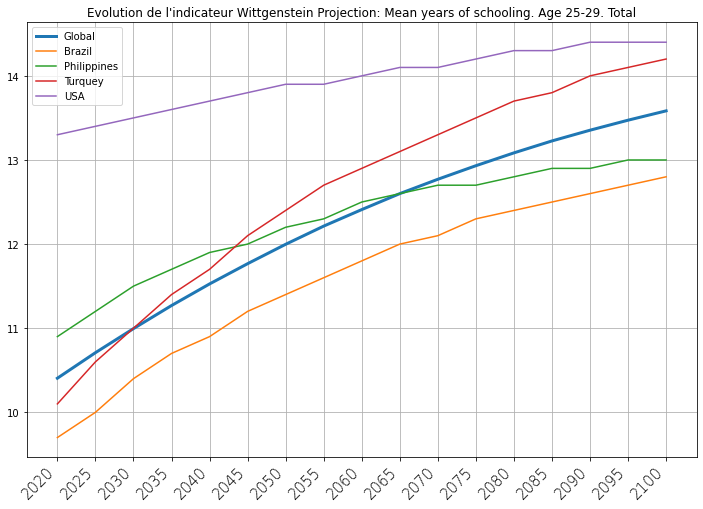

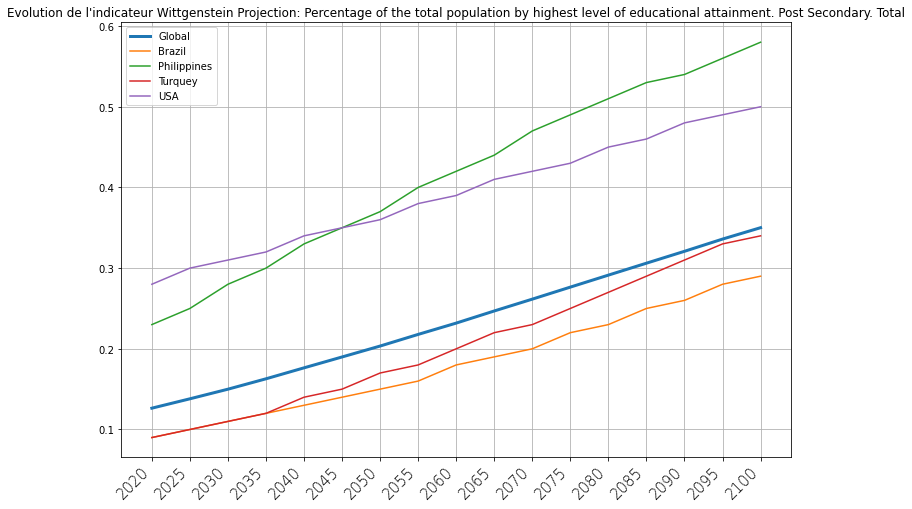

In [43]:
#ind1
ID=id1
Glob_1=df_Data[df_Data['Indicator Name']==ID].loc[:,"2020":"2100"].T

Glob_1['mean']=Glob_1.mean(axis=1)

df_Brazil=df_Data[df_Data['Country Name']=='Brazil']
df_Philippines=df_Data[df_Data['Country Name']=='Philippines']
df_Turquey=df_Data[df_Data['Country Name']=='Turkey']
df_US=df_Data[df_Data['Country Name']=='United States']


fig, ax =plt.subplots(figsize=(12,8))

ax.plot(Glob_1['mean'],label="Global",lw=3)
ax.plot(df_Brazil[df_Brazil['Indicator Name']==ID].T.loc["2020":"2100",:],label='Brazil')
ax.plot(df_Philippines[df_Philippines['Indicator Name']==ID].T.loc["2020":"2100",:],label='Philippines')
ax.plot(df_Turquey[df_Turquey['Indicator Name']==ID].T.loc["2020":"2100",:],label='Turquey')
ax.plot(df_US[df_US['Indicator Name']==ID].T.loc["2020":"2100",:],label='USA')

ax.legend()
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize= 15 )
plt.title("Evolution de l'indicateur "+ID)
plt.grid()
plt.show()

#ind2
ID=id2
Glob_1=df_Data[df_Data['Indicator Name']==ID].loc[:,"2020":"2100"].T
Glob_1['mean']=Glob_1.mean(axis=1)
df_Brazil=df_Data[df_Data['Country Name']=='Brazil']
df_Philippines=df_Data[df_Data['Country Name']=='Philippines']
df_Turquey=df_Data[df_Data['Country Name']=='Turkey']
df_US=df_Data[df_Data['Country Name']=='United States']


fig, ax =plt.subplots(figsize=(12,8))
ax.plot(Glob_1['mean'],label="Global",lw=3)
ax.plot(df_Brazil[df_Brazil['Indicator Name']==ID].T.loc["2020":"2100",:],label='Brazil')
ax.plot(df_Philippines[df_Philippines['Indicator Name']==ID].T.loc["2020":"2100",:],label='Philippines')
ax.plot(df_Turquey[df_Turquey['Indicator Name']==ID].T.loc["2020":"2100",:],label='Turquey')
ax.plot(df_US[df_US['Indicator Name']==ID].T.loc["2020":"2100",:],label='USA')

ax.legend()
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize= 15 )
plt.title("Evolution de l'indicateur "+ID)
plt.grid()
plt.show()
